# Deep Learning with Natural Language Processing on the Yelp reviews dataset

## Reading in some Yelp reviews

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [3]:
# read in the reviews into a DataFrame
yelp = pd.read_csv("yelp_reviews.csv")

In [4]:
print(yelp.shape)
#Looking into the dataset
yelp.head()

#Value counts of 'stars'

yelp['stars'].value_counts()



(1000000, 4)


5    432637
4    229402
1    140308
3    114052
2     83601
Name: stars, dtype: int64

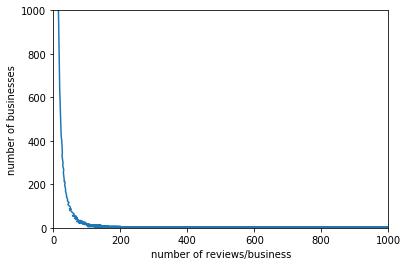

In [5]:
#Figuring out the number of reviews that businesses receive
number_of_reviews = yelp.business_id.value_counts().value_counts().plot()
sns.mpl.pyplot.xlabel("number of reviews/business")
sns.mpl.pyplot.ylabel("number of businesses")
sns.mpl.pyplot.xlim(0,1000)
sns.mpl.pyplot.ylim(0,1000)
sns.mpl.pyplot.show()

#Most businesses have very few reviews. 

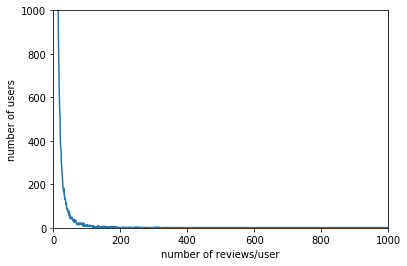

In [6]:
#reviews per user
yelp.user_id.value_counts().value_counts().sort_index().plot()
sns.mpl.pyplot.xlabel("number of reviews/user")
sns.mpl.pyplot.ylabel("number of users")
sns.mpl.pyplot.xlim(0,1000)
sns.mpl.pyplot.ylim(0,1000)
sns.mpl.pyplot.show()

#Both these graphs seem to denote a power law relationship. I plot a log-log plot as the next step

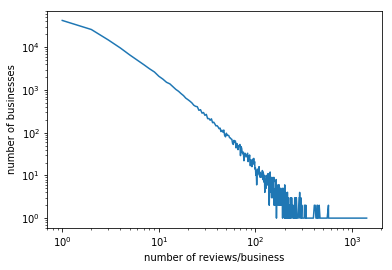

In [7]:
#reviews per business
yelp.business_id.value_counts().value_counts().sort_index().plot(loglog=True)
sns.mpl.pyplot.xlabel("number of reviews/business")
sns.mpl.pyplot.ylabel("number of businesses")
sns.mpl.pyplot.show()

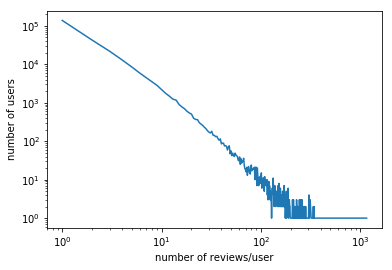

In [8]:
#reviews per user
yelp.user_id.value_counts().value_counts().sort_index().plot(loglog=True)
sns.mpl.pyplot.xlabel("number of reviews/user")
sns.mpl.pyplot.ylabel("number of users")
sns.mpl.pyplot.show()

In [9]:
#To retain meaningful data, we can only look at businesses with > 10 reviews and users with > 10 reviews
#Converting to DataFrame
yelp = pd.DataFrame(yelp)

yelp_smaller = yelp


In [10]:
#keep only businesses with > 10 reviews, users with > 10 reviews
yelp_smaller = yelp.groupby("business_id").filter(lambda x: x.shape[0]>10)
yelp_smaller = yelp_smaller.groupby("user_id").filter(lambda x: x.shape[0]>10)
#and only the 5-star and <=1 star reviews
yelp_smaller = yelp_smaller[(yelp_smaller.stars==5) | (yelp_smaller.stars==1)]
#keep only columns we would want to use later

yelp_smaller["target"] = (yelp_smaller.stars >1).astype(int)
print(yelp_smaller.target.value_counts())

yelp_smaller.reset_index(drop=True,inplace=True)

yelp_smaller.head()

1    95129
0    18562
Name: target, dtype: int64


,business_id,stars,text,user_id,target
0,Aov96CM4FZAXeZvKtsStdA,5,This place is awesome! Definitely authentic!!!...,u0LXt3Uea_GidxRW1xcsfg,1
1,zgQHtqX0gqMw1nlBZl2VnQ,1,really excited to hear of this restaurant comi...,u0LXt3Uea_GidxRW1xcsfg,0
2,hjk3ox7w1akbEuOgTJ03Bw,1,Food is very bland - not authentic at all.\n\n...,u0LXt3Uea_GidxRW1xcsfg,0
3,tOhRQqiupLyJdBJVQMGOEQ,5,OMG - Definitely worth going if you are in Mon...,u0LXt3Uea_GidxRW1xcsfg,1
4,I8rveLd-dl81u6c8YqAxmw,1,If you have not yet tried Wasabi - don't bothe...,u0LXt3Uea_GidxRW1xcsfg,0


- **corpus:** collection of documents
- **corpora:** plural form of corpus

Using StratifiedShuffleSplit to preserve imbalance in the target data

In [21]:
# split the new DataFrame into training and testing sets, keeping relative frequencies of targets unchanged
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state=1)
train_indices,test_indices=list(splitter.split(yelp_smaller.text,yelp_smaller.target))[0]
X_train,y_train = yelp_smaller.text.iloc[train_indices],yelp_smaller.target.iloc[train_indices]
X_test,y_test = yelp_smaller.text.iloc[test_indices],yelp_smaller.target.iloc[test_indices]

In [22]:
y_train.value_counts()/y_train.shape[0]

1    0.836736
0    0.163264
Name: target, dtype: float64

In [23]:
y_test.value_counts()/y_test.shape[0]

1    0.836725
0    0.163275
Name: target, dtype: float64

## Tokenization

In [24]:
# use CountVectorizer to create document-term matrices from X_train and X_test
vect = CountVectorizer(lowercase=False)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)

In [25]:
# rows are documents, columns are features
train_dtm.shape

(79583, 99170)

In [26]:
# last 50 features
print(vect.get_feature_names()[50:500])

['0600', '0601', '0630', '06pm', '07', '0700', '0716', '0730', '074', '0745hrs', '0757', '0777', '079', '07pm', '08', '0800hrs', '0830', '0840', '08am', '09', '090', '0900', '0908', '091', '0912', '094', '09am', '09pm', '0OqUYIsQ', '0P', '0_0', '0admission', '0f', '0ur', '0ut', '0utta', '0z', '10', '100', '1000', '10000', '100000', '1000000', '100000000000', '10000000X', '10000degrees', '1000X', '1000npm', '1000s', '1000x', '1001', '100111fa_fact_seabrook', '1003rd', '1008', '100F', '100Fs', '100K', '100ft', '100g', '100ish', '100k', '100lbs', '100mbps', '100mg', '100ml', '100mm', '100oz', '100percent', '100s', '100th', '100x', '101', '1012', '10127', '10159531', '101st', '102', '1023', '1024GB', '1026', '1029', '103', '1030', '1030am', '1030ish', '10345', '103rd', '104', '1040', '10420', '1045', '1045a', '1045pm', '105', '1057', '105degree', '105each', '105o', '106', '106k', '107', '107th', '108', '1080P', '1082', '108th', '109', '1092nd', '1097967', '109th', '10AM', '10Am', '10DEeac'

In [27]:
# show vectorizer options
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

We do not change the text to lowercase because uppercase reviews might actually convey meaning in this case

In [28]:
# allow tokens of one character
vect = CountVectorizer(token_pattern=r'(?u)\b\w+\b', lowercase= False)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.fit_transform(X_test)
train_dtm.shape

(79583, 99251)

In [29]:
# last 50 features
print(vect.get_feature_names()[-50:])

['這間距離俗稱主街的拉斯維加斯大道有段距離', '這間開設在', '這點是挺好的', '通常都不會讓人太有意外', '造型圓滾討喜的生干貝壽司', '選擇了兩種主餐的組合', '還是吃來爽口的海帶沙拉開胃', '還是建議不要點用', '還會贈送這塊外表釉黑的香蕉蛋糕', '還有一些包括甜椒', '還有不在固定菜單上的烤牛肋排', '還有咖哩魚丸', '還有特別著名哪些是日本進口的食材', '那這裡的烤肉還多了分嬌滴滴的誘人', '郊區', '都是會讓人顧不得吃得滿手肉汁', '都是經典的美式家常風味', '配菜等的內容', '配角也是一時之選', '開店至今超過十多個年頭卻依舊人聲鼎沸', '開設在五光十色越夜越美麗的賭城', '除了造訪在主街大道上那些華麗豐盛的自助餐與名廚餐廳', '雖是預先處理好卻還有不錯的鮮度', '雖然只是中低價位的吃到飽壽司', '雖然單吃蟹肉有點乾', '雖然在壽司臺裡頭可以看到多位壽司師傅同時忙碌工作的身影', '雖然外觀其貌不揚', '雖然捏製的手法與切工並非無懈可擊', '雖然還是有股濃郁的甜味在吃下後在喉間慢慢散開', '雪蟹蟹肉壽司', '食客們絡繹不絕造訪', '餐廳外觀看起來也就像是一間農舍', '餐後甜點選擇炸天婦羅冰淇淋與麻糬冰淇淋', '餐點的內容當然也不可以太平凡', '首先吸引目光的當然就是自助餐中人氣菜色的帝王蟹腳', '首先透過大吃一頓犒賞自己舟車勞頓後的疲憊身軀是必須的', '香檳選用來自法國進口的', '香辣回甘的烤肉醬', '高大上', '鬆軟的香蕉蛋糕', '魚脂的香氣更是豐美', '鮪魚下巴肉軍艦卷', '鮭魚子的彈性尚可', '鮭魚肚肉', '鮮甜爽口', '麵條則是選擇粿條', '點用生魚片沙拉是出於想多吃一點青菜來彌補罪惡感的念頭', '點餐完畢後就找個位置等候叫號取餐', '龍蝦', '龍蝦尾有著一般只在單點的海鮮餐廳或是高級牛排館中才吃得到的水準之作']


**Predicting 5(positive) vs. 1(negative) star rating:**

In [31]:
# # use default options for CountVectorizer
# vect = CountVectorizer(lowercase = False)

vect = CountVectorizer(lowercase=False)
train_dtm = vect.fit_transform(X_train)
test_dtm = vect.transform(X_test)

lr = LogisticRegression()
lr.fit(train_dtm, y_train)
y_pred_class = lr.predict(test_dtm)
print(metrics.accuracy_score(y_test, y_pred_class))



0.9724991204409522


In [32]:
# calculate null accuracy
y_test.mean()

0.8367245221062507

Just using raw counts of different words gives us very good performance!

Let's examine the most positive and most negative words (their coefficients will tell us whether they are most indicative of a positive or negative review).

In [49]:
feature_coeffs = pd.DataFrame(list(zip(vect.get_feature_names(),lr.coef_[0])),columns=["word","coeff"])
feature_coeffs = feature_coeffs.sort_values(by="coeff",ascending=False).reset_index(drop=True)

Words most indicative of positive review:

In [50]:
feature_coeffs.head()

,word,coeff
0,excellent,2.694294
1,Excellent,2.619017
2,Love,2.511644
3,Amazing,2.468672
4,awesome,2.341068


Words most indicative of negative review:

In [51]:
feature_coeffs.tail()

,word,coeff
99165,bland,-2.683588
99166,rude,-2.820977
99167,Worst,-2.855404
99168,poisoning,-3.187329
99169,worst,-3.486393


In [52]:
feature_coeffs["abs_coeff"] = feature_coeffs.coeff.abs()

Most predictive words, regardless of polarity:

In [53]:
feature_coeffs.sort_values(by="abs_coeff",inplace=True,ascending=False)
feature_coeffs.head(100)

,word,coeff,abs_coeff
99169,worst,-3.486393,3.486393
99168,poisoning,-3.187329,3.187329
99167,Worst,-2.855404,2.855404
99166,rude,-2.820977,2.820977
0,excellent,2.694294,2.694294
99165,bland,-2.683588,2.683588
1,Excellent,2.619017,2.619017
99164,overpriced,-2.551787,2.551787
2,Love,2.511644,2.511644
99163,stale,-2.482242,2.482242


Useless words (dont tell you anything about the polarity of the review):

In [54]:
feature_coeffs.tail(20)

,word,coeff,abs_coeff
71144,CHIA,-1.570476e-11,1.570476e-11
71142,GRINDER,-1.570476e-11,1.570476e-11
71146,GRACIAS,-1.570476e-11,1.570476e-11
71145,vibed,-1.570476e-11,1.570476e-11
71143,MUCHAS,-1.570476e-11,1.570476e-11
71139,PUNCH,-1.570476e-11,1.570476e-11
71141,SEEDS,-1.570476e-11,1.570476e-11
71140,MEATBALL,-1.570476e-11,1.570476e-11
71147,omni,-1.570476e-11,1.570476e-11
71129,savages,-1.338362e-11,1.338362e-11


In [55]:
feature_coeffs.head()

,word,coeff,abs_coeff
99169,worst,-3.486393,3.486393
99168,poisoning,-3.187329,3.187329
99167,Worst,-2.855404,2.855404
99166,rude,-2.820977,2.820977
0,excellent,2.694294,2.694294


## Pipelines To Make CV/Transformations Easier With Imbalanced Data

In [56]:
#Building pipelines here for transformations

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [58]:
#Considering a subset of features to make processing faster    
yelp_pipeline = Pipeline([("countVect", CountVectorizer(max_features = 1000)),("logreg", LogisticRegression())])

In [59]:
strat_cv = StratifiedKFold(n_splits=2)

In [60]:
np.mean(cross_val_score(yelp_pipeline,
                yelp_smaller.text,
                yelp_smaller.target,
                scoring="accuracy",
                cv=strat_cv,
                n_jobs=-1,
                verbose=1))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   23.9s finished


0.9624244595055162

In [61]:
yelp_pipeline.fit(yelp_smaller.text,yelp_smaller.target)

C:\Users\Madhu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('countVect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [62]:
# Creating a function that accepts a vectorizer and returns a table with the coefficients and accuracy of cv-ed model
def tokenize_test(vect):
    pipe = Pipeline([("vect",vect),("lr",LogisticRegression())])
    pipe.fit(yelp_smaller.text,yelp_smaller.target)
    num_features = len(pipe.steps[0][1].get_feature_names())
    print('Num Features: ', num_features)

    zipped_coeffs = list(zip(pipe.steps[0][1].get_feature_names(),
                             pipe.steps[1][1].coef_[0]))
    feature_coeffs = pd.DataFrame(zipped_coeffs,columns=["word","coeff"]).sort_values(by="coeff",ascending=False)
    feature_coeffs.reset_index(drop=True,inplace=True)

    strat_cv = StratifiedKFold(n_splits=2)
    acc = np.mean(cross_val_score(pipe,
                yelp_smaller.text,
                yelp_smaller.target,
                scoring="accuracy",
                cv=strat_cv,
                n_jobs=-1,
                verbose=1))
    print("Accuracy:", acc)
    return (feature_coeffs, acc)

In [64]:
# We can customize this vec as we want
vect = CountVectorizer(max_features=1000)
feature_coeffs,acc = tokenize_test(vect)

Num Features:  1000


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy: 0.9624244595055162


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   37.6s finished


In [65]:
feature_coeffs.head(10)

,word,coeff
0,perfection,3.139754
1,excellent,2.518785
2,incredible,2.454573
3,delicious,2.365277
4,perfect,2.263423
5,fantastic,2.165165
6,amazing,2.159723
7,awesome,2.136410
8,favorites,2.035927
9,outstanding,1.998617


In [66]:
feature_coeffs.sort_values("coeff").head(10)

,word,coeff
999,worst,-3.415679
998,bland,-2.805870
997,terrible,-2.641710
996,horrible,-2.565775
995,rude,-2.415158
994,poor,-2.030954
993,unfortunately,-1.789603
992,dirty,-1.546313
991,sorry,-1.490857
990,tasted,-1.273081


## Stopword Removal

In [67]:
# show vectorizer options
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [68]:
# remove English stop words
vect = CountVectorizer(stop_words='english',max_features=1000, min_df=0.005, max_df = 0.7)
feature_coeffs,acc = tokenize_test(vect)

C:\Users\Madhu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Num Features:  1000


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy: 0.9577802972173576


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   28.0s finished


In [69]:
feature_coeffs.head(10)

,word,coeff
0,perfection,3.528816
1,incredible,2.573440
2,excellent,2.571207
3,phenomenal,2.459573
4,delicious,2.402886
5,delish,2.285027
6,fantastic,2.216227
7,amazing,2.188184
8,awesome,2.170301
9,notch,2.162575


In [70]:
feature_coeffs.tail(10).sort_values("coeff")

,word,coeff
999,worst,-3.425752
998,bland,-2.772707
997,horrible,-2.671163
996,awful,-2.648750
995,terrible,-2.634115
994,rude,-2.358596
993,waste,-2.279067
992,poor,-2.092049
991,unfortunately,-1.832535
990,dirty,-1.599597


In [71]:
# set of stop words
print(vect.get_stop_words())

frozenset({'otherwise', 'during', 'she', 'least', 'only', 'with', 'whither', 'there', 'have', 'last', 'to', 'bill', 'nevertheless', 'nobody', 'amoungst', 'hundred', 'here', 'whole', 'everyone', 'each', 'a', 'had', 'may', 'it', 'full', 'no', 'him', 'amongst', 'back', 'via', 'serious', 'off', 'beyond', 'less', 'get', 'throughout', 'themselves', 'all', 'inc', 'for', 'rather', 'though', 'every', 'nowhere', 'my', 'besides', 'yourselves', 'therefore', 'put', 'by', 'mine', 'towards', 'somehow', 'around', 'therein', 'hers', 'then', 'eleven', 'same', 'we', 'or', 'down', 'etc', 'twelve', 'still', 'de', 'about', 'becoming', 'elsewhere', 'becomes', 'hereby', 'beside', 'since', 'his', 'neither', 'them', 'anyhow', 'someone', 'interest', 'on', 'sometime', 'thru', 'enough', 'an', 'made', 'these', 'out', 'seem', 'front', 'also', 'himself', 'sincere', 'often', 'thereby', 'such', 'how', 'must', 'being', 'who', 'seems', 'never', 'others', 'but', 'bottom', 'afterwards', 'forty', 'formerly', 'one', 'found',

## Other CountVectorizer Options

In [72]:
# remove English stop words and only keep words appearing in 0.5% of documents
vect = CountVectorizer(stop_words='english', min_df = 0.005)
features,acc = tokenize_test(vect)

C:\Users\Madhu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Num Features:  1581


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy: 0.9623804876908147


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.1s finished


In [73]:
features.head()

,word,coeff
0,perfection,3.163697
1,incredible,2.679298
2,phenomenal,2.606023
3,excellent,2.605894
4,pleasantly,2.485137


In [74]:
features.sort_values("coeff").head()

,word,coeff
1580,worst,-3.420313
1579,disappointing,-2.992058
1578,disappointment,-2.850296
1577,disgusting,-2.719061
1576,horrible,-2.676040


In [75]:
# include 1-grams and 2-grams, and only include terms that appear at least 20 times
vect = CountVectorizer(ngram_range=(1, 2), min_df=20)
features,acc = tokenize_test(vect)

C:\Users\Madhu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Num Features:  81615


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Accuracy: 0.9783975864387682


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.5min finished


In [101]:
features.head()

,word,coeff
0,excellent,2.524480
1,be disappointed,2.327470
2,not disappointed,2.312735
3,delicious,2.275090
4,awesome,2.140078


In [102]:
features.sort_values("coeff").head()

,word,coeff
99925,worst,-2.961418
99924,not worth,-2.837520
99923,two stars,-2.612489
99922,at best,-2.557048
99921,overpriced,-2.550226


## Using TF-IDF to Summarize a Yelp Review


In [11]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(stop_words='english')
dtm = vect.fit_transform(yelp_smaller.text)
features = vect.get_feature_names()
dtm.shape


(113691, 87434)

In [12]:
from textblob import TextBlob
def summarize():
    
    # choose a random review that is at least 500 characters
    review_length = 0
    while review_length < 500:
        review_id = np.random.randint(0, len(yelp_smaller))
        review_text = yelp_smaller.text.iloc[review_id]
        review_length = len(review_text)
    
    # create a dictionary of words and their TF-IDF scores
    word_scores = {}
    for word in TextBlob(review_text).words:
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[review_id, features.index(word)]
    
    # print words with the top 5 TF-IDF scores
    print('TOP SCORING WORDS:')
    top_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, score in top_scores:
        print(word)
    
    # print 5 random words
    print('\n' + 'RANDOM WORDS:')
    random_words = np.random.choice(list(word_scores.keys()), size=5, replace=False)
    for word in random_words:
        print(word)
    
    # print the review
    print('\n' + review_text)

In [14]:
summarize()

TOP SCORING WORDS:
taco
widely
beans
mexicans
tacos

RANDOM WORDS:
los
make
try
maybe
opinions

Mexicans in town like to complain that Los Tacos is not authentic, they don't make their own tortillas etc, and maybe they're right...but the food is really good nonetheless. I have not found a better carnitas taco. I get it with everything and it's great. In fact everything I've sampled has been excellent. Somebody else posted that they didn't like beans on their taco...then don't order it with beans! Duh!! Opinions vary widely when it comes to tacos but you should definitely give this place a try and make up your own mind.


## Stemming and Lemmatization

In [15]:
# initialize stemmer
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')


review_id = np.random.randint(0, len(yelp_smaller))
review = TextBlob(yelp_smaller.text.iloc[review_id])

# stem each word
print([stemmer.stem(word) for word in review.words])

['my', '3rd', 'transact', 'from', 'the', 'discount', 'tire', 'chain', 'of', 'store', 'and', 'my', 'first', 'at', 'this', 'particular', 'store', 'super', 'bunch', 'of', 'guy', 'to', 'work', 'with', 'from', 'the', 'veri', 'start', 'to', 'the', 'veri', 'end', 'of', 'the', 'sale', 'process', 'the', 'guy', 'at', 'the', 'front', 'desk', 'to', 'the', 'guy', 'in', 'the', 'work', 'shop', 'are', 'all', 'profession', 'i', 'struggl', 'to', 'find', 'good', 'custom', 'servic', 'in', 'ani', 'industri', 'like', 'these', 'guy', 'and', 'this', 'compani', 'deliv', 'i', 'am', 'total', 'satisfi', 'with', 'my', 'bfg', 'km2', 'mt', 'tire', 'purchas', 'mount', 'and', 'over', 'all', 'experi', 'thank', 'guy', 'nice', 'job']


**Lemmatization**

- **What:** Derive the canonical form ('lemma') of a word
- **Why:** Can be better than stemming
- **Notes:** Uses a dictionary-based approach (slower than stemming)

In [16]:
# assume every word is a noun
print([word.lemmatize() for word in review.words])

['My', '3rd', 'transaction', 'from', 'the', 'Discount', 'Tire', 'chain', 'of', 'store', 'and', 'my', 'first', 'at', 'this', 'particular', 'store', 'Super', 'bunch', 'of', 'guy', 'to', 'work', 'with', 'from', 'the', 'very', 'start', 'to', 'the', 'very', 'end', 'of', 'the', 'sale', 'process', 'The', 'guy', 'at', 'the', 'front', 'desk', 'to', 'the', 'guy', 'in', 'the', 'work', 'shop', 'are', 'all', 'professional', 'I', 'struggle', 'to', 'find', 'good', 'customer', 'service', 'in', 'any', 'industry', 'like', 'these', 'guy', 'and', 'this', 'company', 'delivers', 'I', 'am', 'totally', 'satisfied', 'with', 'my', 'BFG', 'KM2', 'MT', 'Tire', 'purchase', 'mount', 'and', 'over', 'all', 'experience', 'Thanks', 'guy', 'Nice', 'job']


In [17]:
# assume every word is a verb
print([word.lemmatize(pos='v') for word in review.words])

['My', '3rd', 'transaction', 'from', 'the', 'Discount', 'Tire', 'chain', 'of', 'store', 'and', 'my', 'first', 'at', 'this', 'particular', 'store', 'Super', 'bunch', 'of', 'guy', 'to', 'work', 'with', 'from', 'the', 'very', 'start', 'to', 'the', 'very', 'end', 'of', 'the', 'sales', 'process', 'The', 'guy', 'at', 'the', 'front', 'desk', 'to', 'the', 'guy', 'in', 'the', 'work', 'shop', 'be', 'all', 'professionals', 'I', 'struggle', 'to', 'find', 'good', 'customer', 'service', 'in', 'any', 'industry', 'like', 'these', 'guy', 'and', 'this', 'company', 'deliver', 'I', 'be', 'totally', 'satisfy', 'with', 'my', 'BFG', 'KM2', 'MT', 'Tire', 'purchase', 'mount', 'and', 'over', 'all', 'experience', 'Thanks', 'guy', 'Nice', 'job']


In [18]:
# define a function that accepts text and returns a list of lemmas
def split_into_lemmas(text):
    text = text.lower()
    words = TextBlob(text).words
    return [word.lemmatize() for word in words]

In [19]:
# use split_into_lemmas as the feature extraction function
vect = CountVectorizer(analyzer=split_into_lemmas)
features,acc = tokenize_test(vect)

NameError: name 'tokenize_test' is not defined

In [20]:
features.head()

AttributeError: 'list' object has no attribute 'head'

In [162]:
features.sort_values("coeff").head()

,word,coeff
127003,worst,-3.293359
127002,poisoning,-3.283280
127001,mediocre,-3.275192
127000,lacked,-3.156390
126999,tasteless,-2.765787


## Sentiment Analysis

In [21]:
print(review)

My 3rd transaction from the Discount Tire chain of stores and my first at this particular store.  Super bunch of guys to work with from the very start to the very end of the sales process.  The guys at the front desk to the guys in the work shop are all professionals.  I struggle to find good customer service in any industry like these guys, and this company delivers.  I am totally satisfied with my BFG KM2 MT Tire purchase, mount and over all experience.  Thanks guys!  Nice job.


In [22]:
# polarity ranges from -1 (most negative) to 1 (most positive)
review.sentiment.polarity

0.31999999999999995

In [23]:
yelp_smaller['length'] = yelp_smaller.text.apply(len)
#Picking a subset of 250 reviews for sentiment analysis
yelp_smaller_subset = yelp_smaller.iloc[1:250, :]

In [24]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [25]:
# create a new DataFrame column for sentiment
yelp_smaller['sentiment'] = yelp_smaller_subset.text.apply(detect_sentiment)

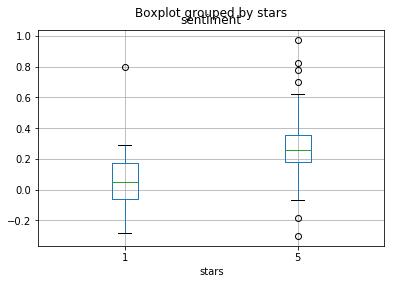

In [26]:
# boxplot of sentiment grouped by stars
yelp_smaller.boxplot(column='sentiment', by='stars')

In [27]:

#Adding the extra feature 'length' to the document term matrix

feature_cols = ['text','length']
X = yelp_smaller[feature_cols]
y = yelp_smaller.target
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [28]:
# use CountVectorizer with text column only
yelp_pipeline = Pipeline([("countVect",CountVectorizer(stop_words="english")),
                     ("lr",LogisticRegression(C=0.1))])
strat_cv = StratifiedKFold(n_splits=2)
text_only_acc = np.mean(cross_val_score(yelp_pipeline,
                        X.text,
                        y,
                        scoring="accuracy",
                        cv=strat_cv,
                        n_jobs=-1,
                        verbose=1))
print("text only accuracy: ",np.round(text_only_acc,4))

NameError: name 'Pipeline' is not defined

In [29]:
print("Original matrix: ",CountVectorizer(stop_words="english").fit_transform(X.text).shape)

Original matrix:  (113691, 87434)


## Applying Word2vec techniques on the yelp dataset





The methods I have used till now involve frequency embedding techniques. I want to try and improve the accuracy of my sentiment analysis by using contextual embedding techniques on a preprocessed dataset. By preprocessing, I mean removal of stopwords and punctuation and so on. Finally I want to try building a convolutional neural network model with feature extraction using word2vec.

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import base64
import string #use for punctuation removal
import re
from collections import Counter
from time import time

#nlp specific libraries
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
nlp = spacy.load('en')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
#For word2vec techniques which are computationally very expensive, I am going to use a smaller subset of the original dataset. 
#This subset contains 20,000 rows of data. It only have reviews with 5 or 1 stars.
yelp = pd.read_csv("yelp_smaller_20k.csv",index_col=0).reset_index(drop=True)
yelp.head()

,business_id,stars,text,user_id
0,8Gi91EkhG2_CJLk_WqjpEg,1,I found them through Craigslist. I did the 2 m...,um0ITBTHoohdozmFA6snlw
1,6zincCvQTb9BsuK-GHZ4cw,5,"Great pizza, excellent delivery time & if I ev...",tNcIhWEeAl607ENbeRSm0w
2,kzANsUYAZFnMsogB1RFE7A,5,Finding an incredible hairstylist is like find...,EJ7ZhRHsMWj8du77LX34gw
3,uBAHE6QOJlndILPIoeEpCQ,1,I attempted to use a coupon for the exact item...,RNVCLdKNddXp8v-y6Aq2Xg
4,yzmvsG3Vo-2_F3_0wHzJdA,1,Dammit! I had such high hopes for this place. ...,D5ETbJC0dptWR07sbTlqRg


In [35]:
print(yelp.stars.value_counts())

print(yelp.stars.value_counts()/len(yelp.stars))

#We can see this dataset is highly imbalanced. We need to deal 

5    15074
1     4926
Name: stars, dtype: int64
5    0.7537
1    0.2463
Name: stars, dtype: float64


In [36]:
#target
yelp["target"] = (yelp.stars == 5).astype(int)

## Text Pre-processing

Below, I perform pre-processing on the text data. The steps include 1) stopword removal 2)lemmatization 3) Removal of punctuation 4) splitting text into sentences. 


In [46]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in nlp.pipe(docs,n_threads=4,disable=["tagger"]):
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation - assuming a period, question mark, exclamation point, and apostroper
        # dictate the end of a given sentence.
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas) from each sentence
        doc = [sent.translate(sent.maketrans("","",string.punctuation)) for sent in doc]
        # Split each sentence into distinct words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [48]:
yelp_cleaned_word2vec = cleanup_text_word2vec(yelp.text, logging=True)

Processed 1000 out of 20000 documents
Processed 2000 out of 20000 documents
Processed 3000 out of 20000 documents
Processed 4000 out of 20000 documents
Processed 5000 out of 20000 documents
Processed 6000 out of 20000 documents
Processed 7000 out of 20000 documents
Processed 8000 out of 20000 documents
Processed 9000 out of 20000 documents
Processed 10000 out of 20000 documents
Processed 11000 out of 20000 documents
Processed 12000 out of 20000 documents
Processed 13000 out of 20000 documents
Processed 14000 out of 20000 documents
Processed 15000 out of 20000 documents
Processed 16000 out of 20000 documents
Processed 17000 out of 20000 documents
Processed 18000 out of 20000 documents
Processed 19000 out of 20000 documents
Processed 20000 out of 20000 documents


In [50]:
#Building a word2vec model

from gensim.models.word2vec import Word2Vec

text_dim = 300

#Using a skip-gram model, so sg = 1
wordvec_model_300 = Word2Vec(yelp_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)

print("%d unique words represented by %d dimensional vectors in this model" % (len(wordvec_model_300.wv.vocab), text_dim))

C:\Users\Madhu\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


13794 unique words represented by 300 dimensional vectors in this model


In [88]:
#Looking into the wordtovec model created above

print("Words most similar to cafe:\n",wordvec_model_300.wv.most_similar(positive=['cafe']))

print("Which of the words breakfast stupid dinner lunch don\'t match: ",wordvec_model_300.wv.doesnt_match("amazing good awesome bland".split()))
print()

print("Words most similar to restaurant - big:\n",wordvec_model_300.wv.most_similar_cosmul(positive=['restaurant'], negative=["big"]))
print()

print("How related is morning to dinner: ",wordvec_model_300.wv.similarity('morning', 'dinner'))
print()
print("How related is night to dinner: ",wordvec_model_300.wv.similarity('night', 'dinner'))

Words most similar to cafe:
 [('café', 0.7632066607475281), ('pub', 0.7278490662574768), ('bistro', 0.725039005279541), ('tavern', 0.7092114686965942), ('eatery', 0.6981256008148193), ('village', 0.6976110339164734), ('uptown', 0.6962024569511414), ('brewery', 0.6920371055603027), ('zen', 0.6786502003669739), ('biltmore', 0.6711153984069824)]
Which of the words breakfast stupid dinner lunch don't match:  bland

Words most similar to restaurant - big:
 [('establishment', 1.3901584148406982), ('cuisine', 1.3776389360427856), ('cafe', 1.323222279548645), ('hotel', 1.319365382194519), ('salon', 1.3096644878387451), ('facility', 1.294703722000122), ('buffet', 1.2864866256713867), ('menu', 1.2801562547683716), ('location', 1.2759960889816284), ('airport', 1.2755135297775269)]

How related is morning to dinner:  0.40573967

How related is night to dinner:  0.656173


## Document classification using Word2vec

For document classification into positive or negative using Word2Vec, I first create a function to compute the average of all the word vectors in a piece of text. After this, I would clean the text in such a way that the information about which reviews each of the sentences belong to is preserved

In [76]:
#Compute average function

def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype = 'float32')
    num_words = 0
    words = doc.split(" ")
    
    for word in words:
        if word in wordvec_model_300.wv.vocab:
            average = np.add(wordvec_model_300[word], average)
            num_words+= 1
    if num_words > 0:
        average = np.divide(average,num_words)
    return average

In [78]:
#Now, we need to re-process the input data such that we retain the indices of each doc. This is so we can apply the create average function on each document in the data

punctuations = string.punctuation

def cleanup_text(docs, logging=True):
    proc_docs = []
    counter = 1
    for doc in nlp.pipe(docs, n_threads=4,disable=["tagger"]):
        if counter % 200 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        tokens = [tok.lemma_.lower().strip() for tok in doc] #lemmatize, remove pronouns #if tok.lemma_ != '-PRON-'
        tokens = [tok for tok in tokens if tok not in stopwords.words() and tok not in punctuations] #remove stopwords, punctuation
        tokens = ' '.join(tokens)
        proc_docs.append(tokens)
    return proc_docs

In [86]:
#Now applying the above function to yelp data. This takes a lot of time to run. So I run it once and now load in the dataset each time

#yelp_smaller_clean = pd.Series(cleanup_text(yelp.text,logging=True))

# LOAD IN THE CLEANED DATA INSTEAD :)
yelp_smaller_clean = pd.read_csv("./yelp_cleaned_word2vec.csv")
yelp_smaller_clean.cleaned_text.fillna("",inplace=True)


,cleaned_text,text,stars,target
0,find craigslist 2 maid 68 dollar two hour firs...,I found them through Craigslist. I did the 2 m...,1,0
1,great pizza excellent delivery time ever back ...,"Great pizza, excellent delivery time & if I ev...",5,1
2,finding incredible hairstylist like find unico...,Finding an incredible hairstylist is like find...,5,1
3,attempt use coupon exact item state picture ma...,I attempted to use a coupon for the exact item...,1,0
4,dammit high hope place -pron- eat month finall...,Dammit! I had such high hopes for this place. ...,1,0


In [89]:
#Applying the create average vector of words function to each document here
final_cleaned_vec = np.zeros((yelp_smaller_clean.shape[0], text_dim), dtype="float32")  # 20000 x 300
for i in range(yelp_smaller_clean.shape[0]):
    final_cleaned_vec[i] = create_average_vec(yelp_smaller_clean.cleaned_text.values[i])

print("Final word vector shape:", final_cleaned_vec.shape)
yelp_smaller_clean.head()


C:\Users\Madhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


Final word vector shape: (20000, 300)


,cleaned_text,text,stars,target
0,find craigslist 2 maid 68 dollar two hour firs...,I found them through Craigslist. I did the 2 m...,1,0
1,great pizza excellent delivery time ever back ...,"Great pizza, excellent delivery time & if I ev...",5,1
2,finding incredible hairstylist like find unico...,Finding an incredible hairstylist is like find...,5,1
3,attempt use coupon exact item state picture ma...,I attempted to use a coupon for the exact item...,1,0
4,dammit high hope place -pron- eat month finall...,Dammit! I had such high hopes for this place. ...,1,0


In [95]:
# Now, we can use this 20000*300 vector as an input to a linear model and a non-linear model. Starting off with Logistic regression
#Finding the cross validated score of Logistic regression using Stratified K-Fold
from sklearn.model_selection import cross_val_score,StratifiedKFold
sk = StratifiedKFold(n_splits = 10)

print(np.mean(cross_val_score(LogisticRegression(), final_cleaned_vec, yelp_smaller_clean.target, cv= sk, scoring = "accuracy")))

C:\Users\Madhu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Madhu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Madhu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Madhu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Madhu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

0.946449464237366


In [96]:
# Using a Random Forest Classifier, we can see that the accuracy of the simpler(logistic) model is more than the Random Forest

from sklearn.ensemble import RandomForestClassifier

sk = StratifiedKFold(n_splits=3)
np.mean(cross_val_score(RandomForestClassifier(n_estimators=50),
                        final_cleaned_vec,
                        yelp_smaller_clean.target,
                        cv=sk,
                        scoring="accuracy"))

0.9277999646372317

As the last step of this project, we can train an MLP and Convolutional Neural Network Model on the data to see if there is an improvement in the accuracy.

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_cleaned_vec, yelp_smaller_clean.target, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print("y-split train:\n",y_train.value_counts()/y_train.shape[0])
print("y-split test:\n",y_test.value_counts()/y_test.shape[0])

X_train size: (16000, 300)
X_test size: (4000, 300)
y_train size: (16000,)
y_test size: (4000,)
y-split train:
 1    0.75575
0    0.24425
Name: target, dtype: float64
y-split test:
 1    0.7455
0    0.2545
Name: target, dtype: float64


In [102]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

#Below, I build a Multi Layered Perceptron (Perceptrons with dropout at each step to prevent overfitting followed by sigmoid activation layer) and CNN (Convolution Filter + Relu Activation followed by Max pooling (and maybe dropout)) model followed by sigmoid activation)

def build_deeplearning_model(model_type = "mlp", input_dim = 300):
    model = Sequential()
    if model_type == "mlp":
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'sigmoid'))
    elif model_type == "cnn":
        inputs = Input(shape=(input_dim,1))
        x = Conv1D(64, 3, strides=1, padding='same', kernel_initializer="uniform",activation='relu')(inputs)
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', kernel_initializer="uniform",activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(1, kernel_initializer="uniform", activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    return model
    

        



Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'